# **CW5 - MSCI151: MILP staffing models (Baseline, Scenario A, Scenario B, Fairness)**

Author: Pramudhita Nirmala Dewi (200000151)

Usage: ipynb

Notes: This script implements the coursework models using PuLP + CBC (default).

### Install and Imports

In [14]:
!pip -q install pulp pandas numpy tabulate

import pulp as pl
import pandas as pd
import numpy as np
from collections import defaultdict
from tabulate import tabulate
import os, json, textwrap, math, datetime

### Data (from CW5 PDF)

In [15]:
# Sets
baristas = ["Max", "Jiwa", "Fore", "Donna", "Paul"]
days = list(range(1, 8))                 # 1..7 (Mon..Sun)
blocks_4 = [1, 2, 3, 4]                  # 4 blocks (07–23)
blocks_3 = [1, 2, 3]                     # for "close at 19:00" scenario
H = 4                                    # hours per block

DAY_NAME = {1:"Mon",2:"Tue",3:"Wed",4:"Thu",5:"Fri",6:"Sat",7:"Sun"}
BLOCK_NAME = {1:"07:00–11:00",2:"11:00–15:00",3:"15:00–19:00",4:"19:00–23:00"}

emp_type = {"Max":"P", "Jiwa":"P", "Fore":"P", "Donna":"F", "Paul":"F"}

# Hourly wages (IDR)
wage = {"Max":50000, "Jiwa":50000, "Fore":50000, "Donna":150000, "Paul":150000}

# Weekly minimum hours
min_weekly_default = {"Max":12, "Jiwa":12, "Fore":12, "Donna":36, "Paul":36}

# Availability table a_{o,d} in HOURS (from PDF)
avail_default = {
    ("Max",1):8, ("Max",2):8, ("Max",3):8, ("Max",4):0, ("Max",5):8, ("Max",6):4, ("Max",7):4,
    ("Jiwa",1):4, ("Jiwa",2):4, ("Jiwa",3):8, ("Jiwa",4):8, ("Jiwa",5):0, ("Jiwa",6):4, ("Jiwa",7):0,
    ("Fore",1):8, ("Fore",2):0, ("Fore",3):8, ("Fore",4):8, ("Fore",5):8, ("Fore",6):8, ("Fore",7):0,
    ("Donna",1):12, ("Donna",2):12, ("Donna",3):12, ("Donna",4):12, ("Donna",5):12, ("Donna",6):12, ("Donna",7):8,
    ("Paul",1):12, ("Paul",2):8, ("Paul",3):12, ("Paul",4):12, ("Paul",5):8, ("Paul",6):12, ("Paul",7):12,
}

# Contractual daily block caps (explicit even if redundant with availability)
daily_block_cap = {"P":2, "F":3}

### Helpers (Extract Solution and Tables)

In [16]:
def solve(prob, msg=True, time_limit=None):
    solver = pl.PULP_CBC_CMD(msg=msg, timeLimit=time_limit) if time_limit else pl.PULP_CBC_CMD(msg=msg)
    prob.solve(solver)
    return pl.LpStatus[prob.status]

def hours_per_barista(y, use_days, use_blocks):
    hrs = {}
    for o in baristas:
        hrs[o] = H * sum(pl.value(y[o][d][b]) for d in use_days for b in use_blocks)
    return hrs

def schedule_table(y, use_days, use_blocks):
    # Allows multiple baristas per block (needed for skills/min-hour overlap scenarios)
    rows = []
    for d in use_days:
        row = {"Day": DAY_NAME[d]}
        for b in use_blocks:
            staff = [o for o in baristas if pl.value(y[o][d][b]) > 0.5]
            row[BLOCK_NAME.get(b, f"Block {b}")] = ", ".join(staff) if staff else "—"
        rows.append(row)
    return pd.DataFrame(rows)

def cost_value(y, use_days, use_blocks, wage_map):
    return sum(H * wage_map[o] * pl.value(y[o][d][b]) for o in baristas for d in use_days for b in use_blocks)

def print_section(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

---

## **Baseline Model Builder (Part A)**

In [17]:
def build_baseline_model(use_blocks, avail, min_weekly, wage_map, model_name="Baseline"):
    prob = pl.LpProblem(model_name, pl.LpMinimize)

    # Decision variables y[o][d][b] ∈ {0,1}
    y = {o: {d: {b: pl.LpVariable(f"y_{o}_{d}_{b}", cat="Binary")
                for b in use_blocks}
             for d in days}
         for o in baristas}

    # Objective: minimize total cost
    prob += pl.lpSum(H * wage_map[o] * y[o][d][b] for o in baristas for d in days for b in use_blocks)

    # (1) Coverage: at least 1 barista per day/block
    for d in days:
        for b in use_blocks:
            prob += pl.lpSum(y[o][d][b] for o in baristas) >= 1, f"coverage_d{d}_b{b}"

    # (2) Availability: H * sum_b y[o,d,b] <= a[o,d]
    for o in baristas:
        for d in days:
            prob += H * pl.lpSum(y[o][d][b] for b in use_blocks) <= avail[(o, d)], f"avail_{o}_d{d}"

    # (3) Daily block cap by contract type
    for o in baristas:
        cap = daily_block_cap[emp_type[o]]
        for d in days:
            prob += pl.lpSum(y[o][d][b] for b in use_blocks) <= cap, f"cap_{o}_d{d}"

    # (4) Weekly minimum hours: H * sum_{d,b} y[o,d,b] >= minWeekly[o]
    for o in baristas:
        prob += H * pl.lpSum(y[o][d][b] for d in days for b in use_blocks) >= min_weekly[o], f"minweekly_{o}"

    return prob, y

## **Fairness Model Builder (Part B)**

In [18]:
def build_fairness_model(use_blocks, avail, min_weekly, wage_map, baseline_cost, cap_ratio=1.02, model_name="Fairness"):
    prob = pl.LpProblem(model_name, pl.LpMinimize)

    y = {o: {d: {b: pl.LpVariable(f"y_{o}_{d}_{b}", cat="Binary")
                for b in use_blocks}
             for d in days}
         for o in baristas}

    # Weekly hours variables
    Hmax = pl.LpVariable("H_max", lowBound=0)
    Hmin = pl.LpVariable("H_min", lowBound=0)

    # Objective: minimize inequity = Hmax - Hmin
    prob += (Hmax - Hmin)

    # Coverage
    for d in days:
        for b in use_blocks:
            prob += pl.lpSum(y[o][d][b] for o in baristas) >= 1

    # Availability + daily caps + weekly minima
    for o in baristas:
        cap = daily_block_cap[emp_type[o]]
        for d in days:
            prob += H * pl.lpSum(y[o][d][b] for b in use_blocks) <= avail[(o, d)]
            prob += pl.lpSum(y[o][d][b] for b in use_blocks) <= cap
        prob += H * pl.lpSum(y[o][d][b] for d in days for b in use_blocks) >= min_weekly[o]

    # Link Hmax/Hmin to each barista’s weekly hours
    for o in baristas:
        weekly_hours_o = H * pl.lpSum(y[o][d][b] for d in days for b in use_blocks)
        prob += weekly_hours_o <= Hmax
        prob += weekly_hours_o >= Hmin

    # Budget constraint: Z <= cap_ratio * Z_baseline
    total_cost = pl.lpSum(H * wage_map[o] * y[o][d][b] for o in baristas for d in days for b in use_blocks)
    prob += total_cost <= cap_ratio * baseline_cost

    return prob, y, Hmax, Hmin, total_cost

## **Skills Variant Builder**

In [19]:
def build_skills_variant(use_blocks, avail, min_weekly, wage_map, senior_required_blocks, senior_set,
                         soft=False, penalty_per_violation=10**9, model_name="SkillsVariant"):
    """
    senior_required_blocks: dict (d,b)->0/1 requirement for a senior on that day/block
    senior_set: set of baristas considered "senior"
    soft: if True, allow violations with slack variables and big penalty
    """
    prob, y = build_baseline_model(use_blocks, avail, min_weekly, wage_map, model_name=model_name)

    slack = {}
    for d in days:
        for b in use_blocks:
            req = senior_required_blocks.get((d,b), 0)
            if req == 1:
                if soft:
                    slack[(d,b)] = pl.LpVariable(f"slack_senior_{d}_{b}", lowBound=0, cat="Integer")
                    prob += pl.lpSum(y[o][d][b] for o in senior_set) + slack[(d,b)] >= 1
                else:
                    prob += pl.lpSum(y[o][d][b] for o in senior_set) >= 1

    if soft and slack:
        prob += penalty_per_violation * pl.lpSum(slack.values())

    return prob, y, slack

## **Runner: Baseline + Scenarios + Fairness + Skills Variant + Sensitivity Analysis**

In [20]:
def run_and_report(label, prob, y, use_blocks, msg=False, time_limit=None):
    status = solve(prob, msg=msg, time_limit=time_limit)
    hrs = hours_per_barista(y, days, use_blocks)
    total_cost = cost_value(y, days, use_blocks, wage)
    print_section(label)
    print(f"Status: {status}")
    print(f"Total cost (IDR): {total_cost:,.0f}")
    print("Weekly hours per barista:", hrs)
    print("\nSchedule table:")
    sched = schedule_table(y, days, use_blocks)
    print(tabulate(sched, headers="keys", tablefmt="github", showindex=False))
    return status, total_cost, hrs, sched

# ---- Baseline (Part A)
prob_base, y_base = build_baseline_model(
    use_blocks=blocks_4,
    avail=avail_default,
    min_weekly=min_weekly_default,
    wage_map=wage,
    model_name="CW5_Baseline"
)
st_base, Z_base, hrs_base, sched_base = run_and_report("PART A — BASELINE (open 07:00–23:00)", prob_base, y_base, blocks_4, msg=False, time_limit=300)

# ---- Scenario 1: close at 19:00 (remove block 4)
prob_close19, y_close19 = build_baseline_model(
    use_blocks=blocks_3,
    avail=avail_default,
    min_weekly=min_weekly_default,
    wage_map=wage,
    model_name="Scenario_Close19"
)
st_c19, Z_c19, hrs_c19, sched_c19 = run_and_report("SENSITIVITY — CLOSE AT 19:00 (remove block 4)", prob_close19, y_close19, blocks_3, msg=False, time_limit=300)

# ---- Scenario 2: PT minimum weekly hours 12 -> 16
min_weekly_pt16 = dict(min_weekly_default)
for o in baristas:
    if emp_type[o] == "P":
        min_weekly_pt16[o] = 16

prob_pt16, y_pt16 = build_baseline_model(
    use_blocks=blocks_4,
    avail=avail_default,
    min_weekly=min_weekly_pt16,
    wage_map=wage,
    model_name="Scenario_PTmin16"
)
st_pt16, Z_pt16, hrs_pt16, sched_pt16 = run_and_report("SENSITIVITY — PART-TIME MIN HOURS = 16", prob_pt16, y_pt16, blocks_4, msg=False, time_limit=300)

# ---- Part B: Fairness variant (inequity minimization with 2% budget cap)
if st_base in ("Optimal", "Feasible"):
    prob_fair, y_fair, Hmax, Hmin, total_cost_expr = build_fairness_model(
        use_blocks=blocks_4,
        avail=avail_default,
        min_weekly=min_weekly_default,
        wage_map=wage,
        baseline_cost=Z_base,
        cap_ratio=1.02,
        model_name="CW5_Fairness"
    )
    st_fair, Z_fair, hrs_fair, sched_fair = run_and_report("PART B — FAIRNESS VARIANT (minimize Hmax-Hmin; cost ≤ 102% of baseline)", prob_fair, y_fair, blocks_4, msg=False, time_limit=300)
    print(f"Inequity (Hmax-Hmin): {pl.value(Hmax - Hmin):,.0f} hours")

# ---- Skills variant
# Define seniors (assumption for skills variant): full-timers are "senior-certified"
senior_set = {o for o in baristas if emp_type[o] == "F"}

# Case A: senior required for EVERY block (strict)
req_all = {(d,b):1 for d in days for b in blocks_4}
prob_skill_strict, y_skill_strict, slack_strict = build_skills_variant(
    use_blocks=blocks_4,
    avail=avail_default,
    min_weekly=min_weekly_default,
    wage_map=wage,
    senior_required_blocks=req_all,
    senior_set=senior_set,
    soft=False,
    model_name="Skills_StrictSeniorEveryBlock"
)
st_ss, Z_ss, hrs_ss, sched_ss = run_and_report("SKILLS VARIANT — SENIOR REQUIRED EACH BLOCK (STRICT)", prob_skill_strict, y_skill_strict, blocks_4, msg=False, time_limit=300)

# Case B: if strict is infeasible or too costly, relax to peak blocks only (2 & 3)
req_peak = {(d,b):1 for d in days for b in [2,3]}
prob_skill_peak, y_skill_peak, slack_peak = build_skills_variant(
    use_blocks=blocks_4,
    avail=avail_default,
    min_weekly=min_weekly_default,
    wage_map=wage,
    senior_required_blocks=req_peak,
    senior_set=senior_set,
    soft=False,
    model_name="Skills_PeakSeniorOnly"
)
st_sp, Z_sp, hrs_sp, sched_sp = run_and_report("SKILLS VARIANT — SENIOR REQUIRED PEAK BLOCKS ONLY", prob_skill_peak, y_skill_peak, blocks_4, msg=False, time_limit=300)

# ---- Short sensitivity insights: wages ±10%
def run_wage_sensitivity(mult_pt=1.0, mult_ft=1.0, label="Wage sensitivity"):
    wage_adj = {}
    for o in baristas:
        wage_adj[o] = int(round(wage[o] * (mult_pt if emp_type[o]=="P" else mult_ft)))
    # Fix the warning by replacing spaces in the model name
    prob, y = build_baseline_model(blocks_4, avail_default, min_weekly_default, wage_adj, model_name=f"Wage_{label.replace(' ', '_')}")
    status = solve(prob, msg=False, time_limit=300)
    hrs = hours_per_barista(y, days, blocks_4)
    Z = cost_value(y, days, blocks_4, wage_adj)
    return {
        "Case": label,
        "Status": status,
        "Cost_IDR": Z,
        "PT_Multiplier": mult_pt,
        "FT_Multiplier": mult_ft,
        "Hours": hrs
    }

print_section("SENSITIVITY — WAGES ±10% (PART-TIME and FULL-TIME)")
wage_sensitivity_results = []
for mpt, mft, lab in [
    (0.9, 1.0, "PT -10%"), (1.1, 1.0, "PT +10%"),
    (1.0, 0.9, "FT -10%"), (1.0, 1.1, "FT +10%"),
    (0.9, 0.9, "ALL -10%"), (1.1, 1.1, "ALL +10%"),
]:
    result = run_wage_sensitivity(mpt, mft, lab)
    wage_sensitivity_results.append(result)

df_wage_sensitivity = pd.DataFrame(wage_sensitivity_results)
df_wage_sensitivity['Cost_IDR'] = df_wage_sensitivity['Cost_IDR'].apply(lambda x: f'{x:,.0f}')
print(tabulate(df_wage_sensitivity, headers="keys", tablefmt="github", showindex=False))

# ---- Short sensitivity insights: barista unavailable for a day
print_section("SENSITIVITY — BARISTA UNAVAILABLE FOR ONE DAY")
# Example: Donna unavailable on Wednesday (day 3)
avail_unavail = dict(avail_default)
avail_unavail[("Donna", 3)] = 0

prob_un, y_un = build_baseline_model(blocks_4, avail_unavail, min_weekly_default, wage, model_name="Unavailability_Donna_Wed")
st_un, Z_un, hrs_un, sched_un = run_and_report("UNAVAILABILITY — DONNA UNAVAILABLE ON WED", prob_un, y_un, blocks_4, msg=False, time_limit=300)


PART A — BASELINE (open 07:00–23:00)
Status: Optimal
Total cost (IDR): 12,800,000
Weekly hours per barista: {'Max': 12.0, 'Jiwa': 12.0, 'Fore': 16.0, 'Donna': 36.0, 'Paul': 36.0}

Schedule table:
| Day   | 07:00–11:00   | 11:00–15:00   | 15:00–19:00   | 19:00–23:00   |
|-------|---------------|---------------|---------------|---------------|
| Mon   | Donna         | Paul          | Max           | Jiwa          |
| Tue   | Donna         | Donna         | Jiwa          | Max           |
| Wed   | Paul          | Fore          | Fore          | Paul          |
| Thu   | Donna         | Paul          | Donna         | Paul          |
| Fri   | Paul          | Fore          | Fore          | Paul          |
| Sat   | Donna         | Jiwa          | Donna         | Max           |
| Sun   | Paul          | Donna         | Paul          | Donna         |

SENSITIVITY — CLOSE AT 19:00 (remove block 4)
Status: Optimal
Total cost (IDR): 12,600,000
Weekly hours per barista: {'Max': 12.0, 'Jiwa

## **Summary Table for the Report Appendix**

In [21]:
summary_rows = []
summary_rows.append({"Case":"Baseline", "Status":st_base, "Cost_IDR":Z_base})
summary_rows.append({"Case":"Close19", "Status":st_c19, "Cost_IDR":Z_c19})
summary_rows.append({"Case":"PTmin16", "Status":st_pt16, "Cost_IDR":Z_pt16})
if 'st_fair' in globals():
    summary_rows.append({"Case":"Fairness", "Status":st_fair, "Cost_IDR":Z_fair})
summary_rows.append({"Case":"Skills_Strict", "Status":st_ss, "Cost_IDR":Z_ss})
summary_rows.append({"Case":"Skills_PeakOnly", "Status":st_sp, "Cost_IDR":Z_sp})
summary_rows.append({"Case":"Unavail_Donna_Wed", "Status":st_un, "Cost_IDR":Z_un})

df_summary = pd.DataFrame(summary_rows)
df_summary['Cost_IDR'] = df_summary['Cost_IDR'].apply(lambda x: f'{x:,.0f}')
print_section("COST SUMMARY (IDR)")
print(tabulate(df_summary, headers="keys", tablefmt="github", showindex=False))


COST SUMMARY (IDR)
| Case              | Status   | Cost_IDR   |
|-------------------|----------|------------|
| Baseline          | Optimal  | 12,800,000 |
| Close19           | Optimal  | 12,600,000 |
| PTmin16           | Optimal  | 13,200,000 |
| Fairness          | Optimal  | 13,000,000 |
| Skills_Strict     | Optimal  | 18,600,000 |
| Skills_PeakOnly   | Optimal  | 12,800,000 |
| Unavail_Donna_Wed | Optimal  | 12,800,000 |


## Visualization

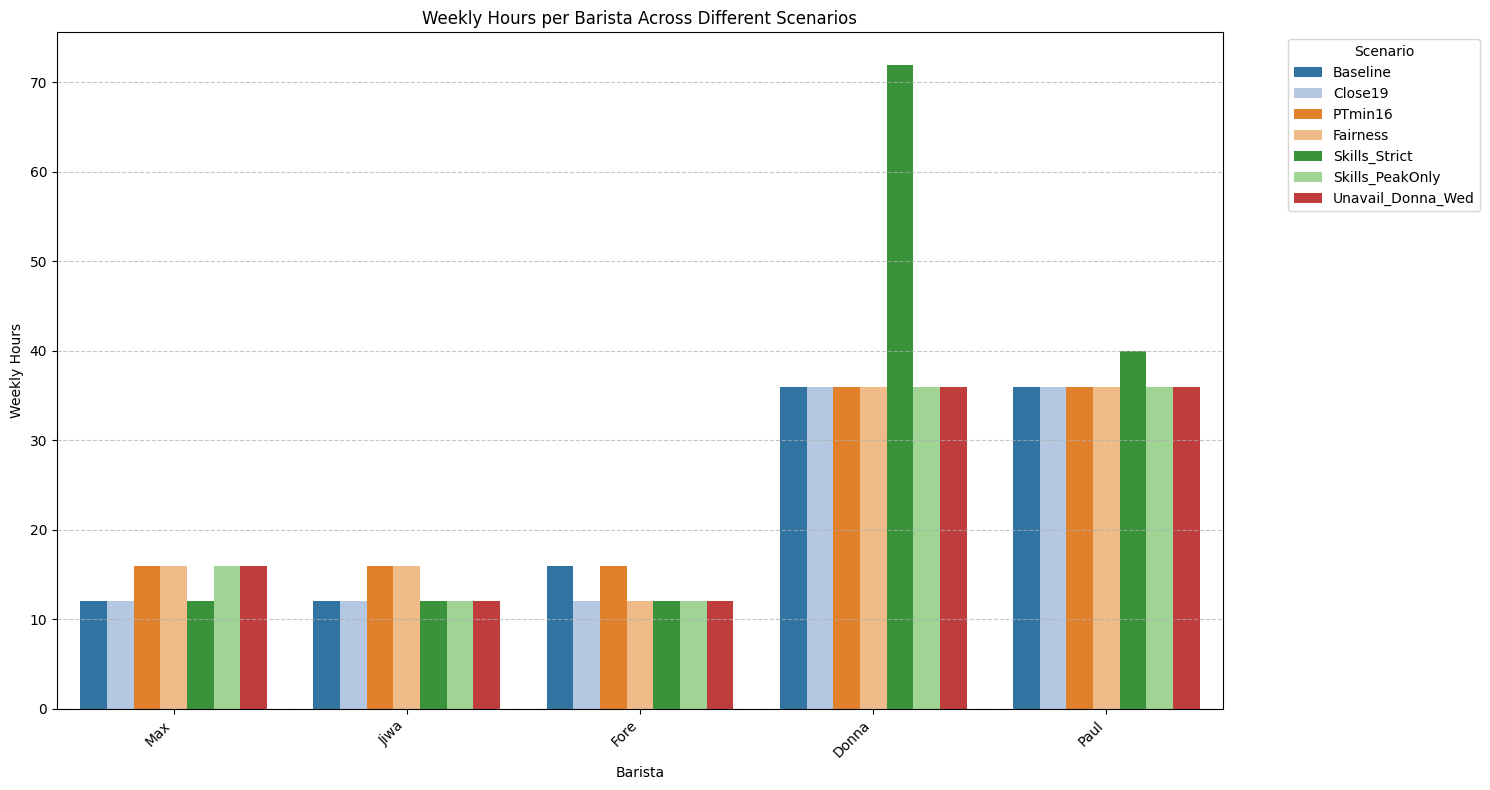

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Consolidate weekly hours into a DataFrame
hours_data = {
    'Barista': baristas,
    'Baseline': [hrs_base[b] for b in baristas],
    'Close19': [hrs_c19[b] for b in baristas],
    'PTmin16': [hrs_pt16[b] for b in baristas],
    'Fairness': [hrs_fair[b] for b in baristas],
    'Skills_Strict': [hrs_ss[b] for b in baristas],
    'Skills_PeakOnly': [hrs_sp[b] for b in baristas],
    'Unavail_Donna_Wed': [hrs_un[b] for b in baristas]
}
df_weekly_hours = pd.DataFrame(hours_data)

# Melt the DataFrame for seaborn plotting
df_weekly_hours_melted = df_weekly_hours.melt(id_vars='Barista', var_name='Scenario', value_name='Weekly_Hours')

plt.figure(figsize=(15, 8))
sns.barplot(x='Barista', y='Weekly_Hours', hue='Scenario', data=df_weekly_hours_melted, palette='tab20')
plt.title('Weekly Hours per Barista Across Different Scenarios')
plt.xlabel('Barista')
plt.ylabel('Weekly Hours')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipython-input-3561275408.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Case', y='Cost_IDR_Numeric', data=df_summary, palette='viridis')


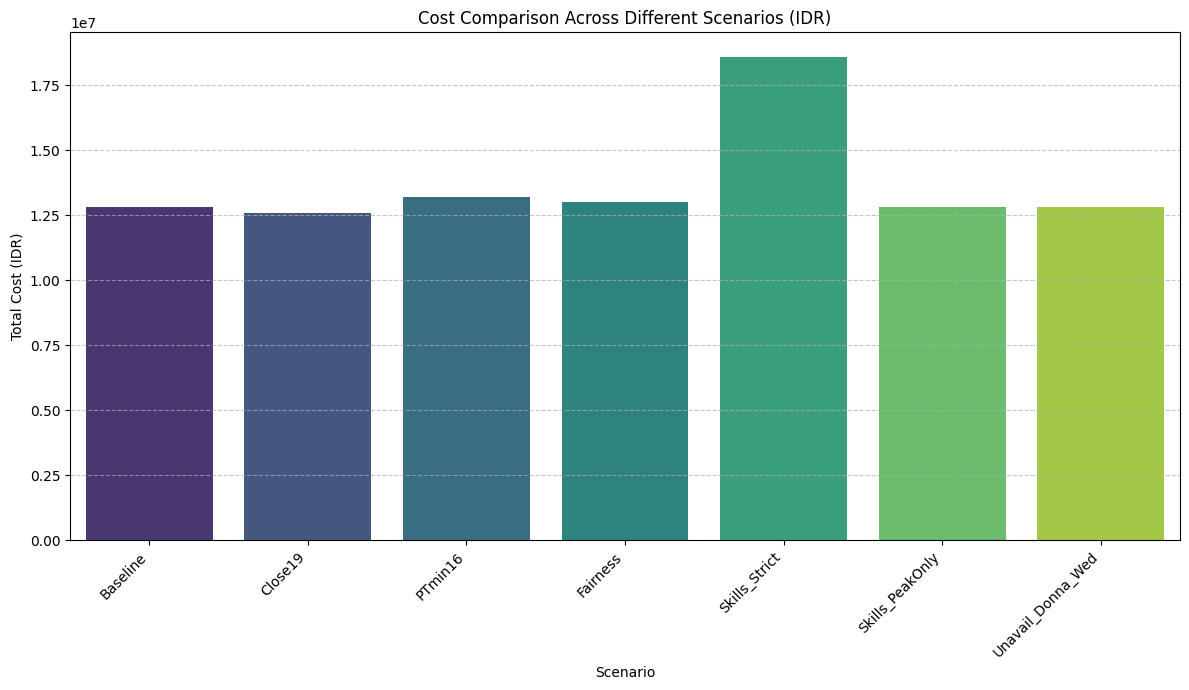

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for summary visualization
df_summary['Cost_IDR_Numeric'] = df_summary['Cost_IDR'].str.replace(',', '').astype(float)

plt.figure(figsize=(12, 7))
sns.barplot(x='Case', y='Cost_IDR_Numeric', data=df_summary, palette='viridis')
plt.title('Cost Comparison Across Different Scenarios (IDR)')
plt.xlabel('Scenario')
plt.ylabel('Total Cost (IDR)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2922025568.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Case', y='Cost_IDR_Numeric', data=df_wage_sensitivity, palette='mako')


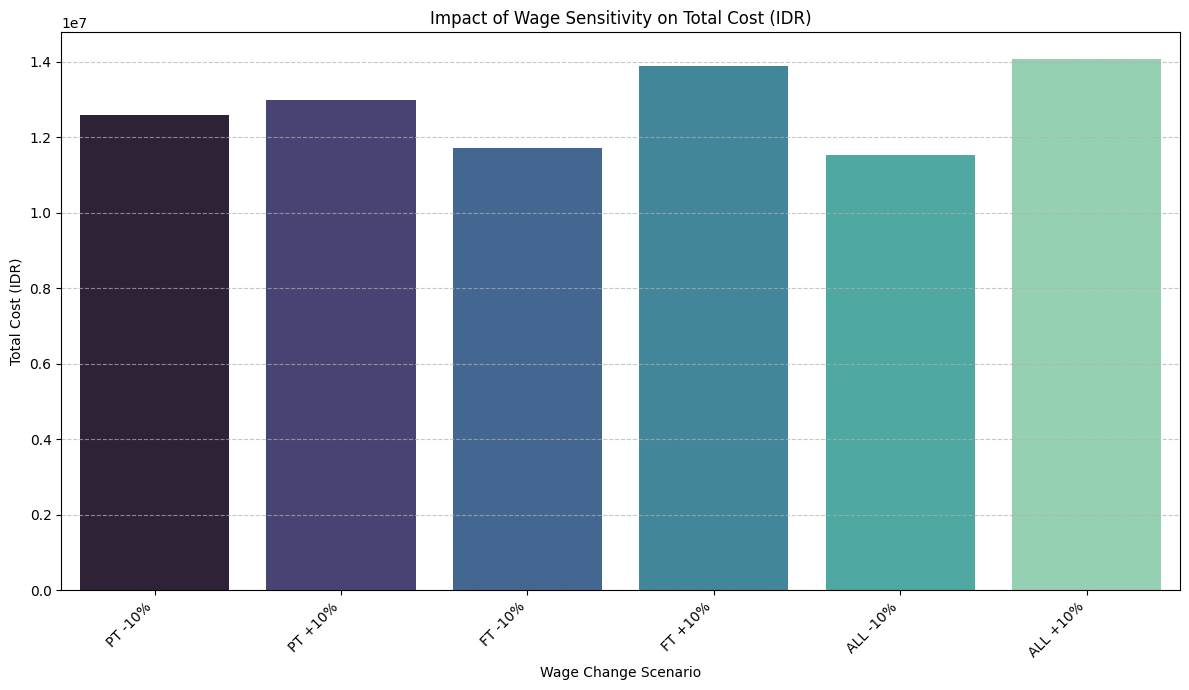

In [24]:
df_wage_sensitivity['Cost_IDR_Numeric'] = df_wage_sensitivity['Cost_IDR'].str.replace(',', '').astype(float)

plt.figure(figsize=(12, 7))
sns.barplot(x='Case', y='Cost_IDR_Numeric', data=df_wage_sensitivity, palette='mako')
plt.title('Impact of Wage Sensitivity on Total Cost (IDR)')
plt.xlabel('Wage Change Scenario')
plt.ylabel('Total Cost (IDR)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()